# Data download

In [1]:
import requests
from tqdm import tqdm, trange
import os

def download(url, fname):
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get('content-length', 0))
    with open(fname, 'wb') as file, tqdm(
            desc=fname,
            total=total,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
    ) as bar:
        for data in resp.iter_content(chunk_size=1024):
            size = file.write(data)
            bar.update(size)
            

In [2]:
url_data = 'https://zenodo.org/record/7343112/files/Cell_ISM_dataset.h5'
name_data = 'Cell_ISM_dataset.h5'
if not os.path.isfile(name_data):
    download(url_data, name_data)
else:
    print('File already downloaded.')

File already downloaded.


In [3]:
url_psf = 'https://zenodo.org/record/7343112/files/PSF_ISM_dataset.h5'
name_psf = 'PSF_ISM_dataset.h5'
if not os.path.isfile(name_psf):
    download(url_psf, name_psf)
else:
    print('File already downloaded.')

File already downloaded.


# Import BrightEyes-ISM

In [4]:
import brighteyes_ism.analysis.APR_lib as apr
import brighteyes_ism.analysis.FRC_lib as frc
import brighteyes_ism.analysis.Deconv_lib as dec
import brighteyes_ism.analysis.FocusISM_lib as fism
import brighteyes_ism.analysis.Graph_lib as gr
import brighteyes_ism.analysis.Tools_lib as tools
import brighteyes_ism.dataio.mcs as mcs
import matplotlib.pyplot as plt
import numpy as np

# Data Loading

In [5]:
data, meta = mcs.load(name_data)
data = tools.CropEdge(data, npx=10, edges='lrud', order = 'rzxytc')
data = tools.DownSample(data, ds = 2, order = 'rzxytc')
pxsizex = 2*meta.dx

In [6]:
print('Dataset shape: ' + str(data.shape) + '\n')
meta.Print()

Dataset shape: (1, 1, 490, 490, 50, 25)

version       0.0.1
comment       
rangex        40.0
rangey        40.0
rangez        0.0
nbin          50
dt            1.0
nx            1000
ny            1000
nz            1
nrep          1
calib_x       17.303
calib_y       17.409
calib_z       10.0


In [7]:
data_psf, meta_psf = mcs.load(name_psf)
data_psf = tools.CropEdge(data_psf, npx=10, edges='lrud', order = 'rzxytc')
data_psf = tools.DownSample(data_psf, ds = 2, order = 'rzxytc')

In [8]:
print('Dataset shape: ' + str(data_psf.shape) + '\n')
meta_psf.Print()

Dataset shape: (40, 1, 50, 50, 50, 25)

version       0.0.1
comment       
rangex        4.8
rangey        4.8
rangez        0.0
nbin          50
dt            1.0
nx            120
ny            120
nz            1
nrep          40
calib_x       17.303
calib_y       17.409
calib_z       10.0


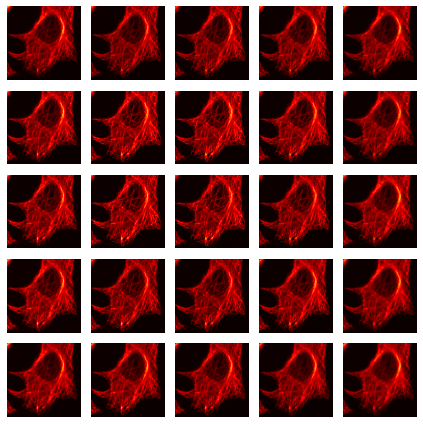

In [9]:
dset = data.sum(axis = (0, 1, 4))
fig = gr.ShowDataset(dset)

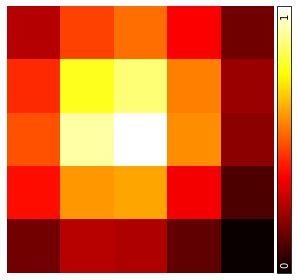

In [10]:
fingerprint = tools.fingerprint(dset)

fig, ax = gr.ShowFingerprint(dset, colorbar = True, normalize = True)

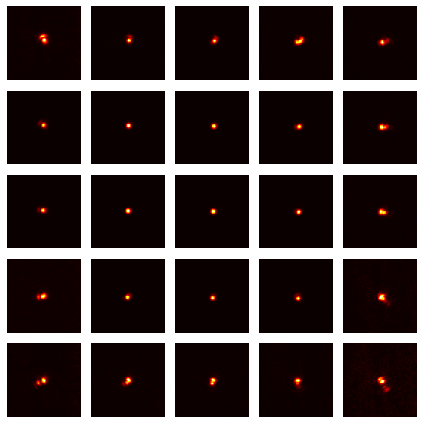

In [11]:
dset_psf = data_psf.sum(axis = (0, 1, 4))
fig = gr.ShowDataset(dset_psf)

# Adaptive Pixel Reassignment

In [12]:
img_sum = dset.sum(axis=-1)

N = dset.shape[-1]
usf = 100
ref = N//2

shift, img_ism = apr.APR(dset, usf, ref, pxsize = pxsizex)

img_ism_sum = img_ism.sum(axis=-1)

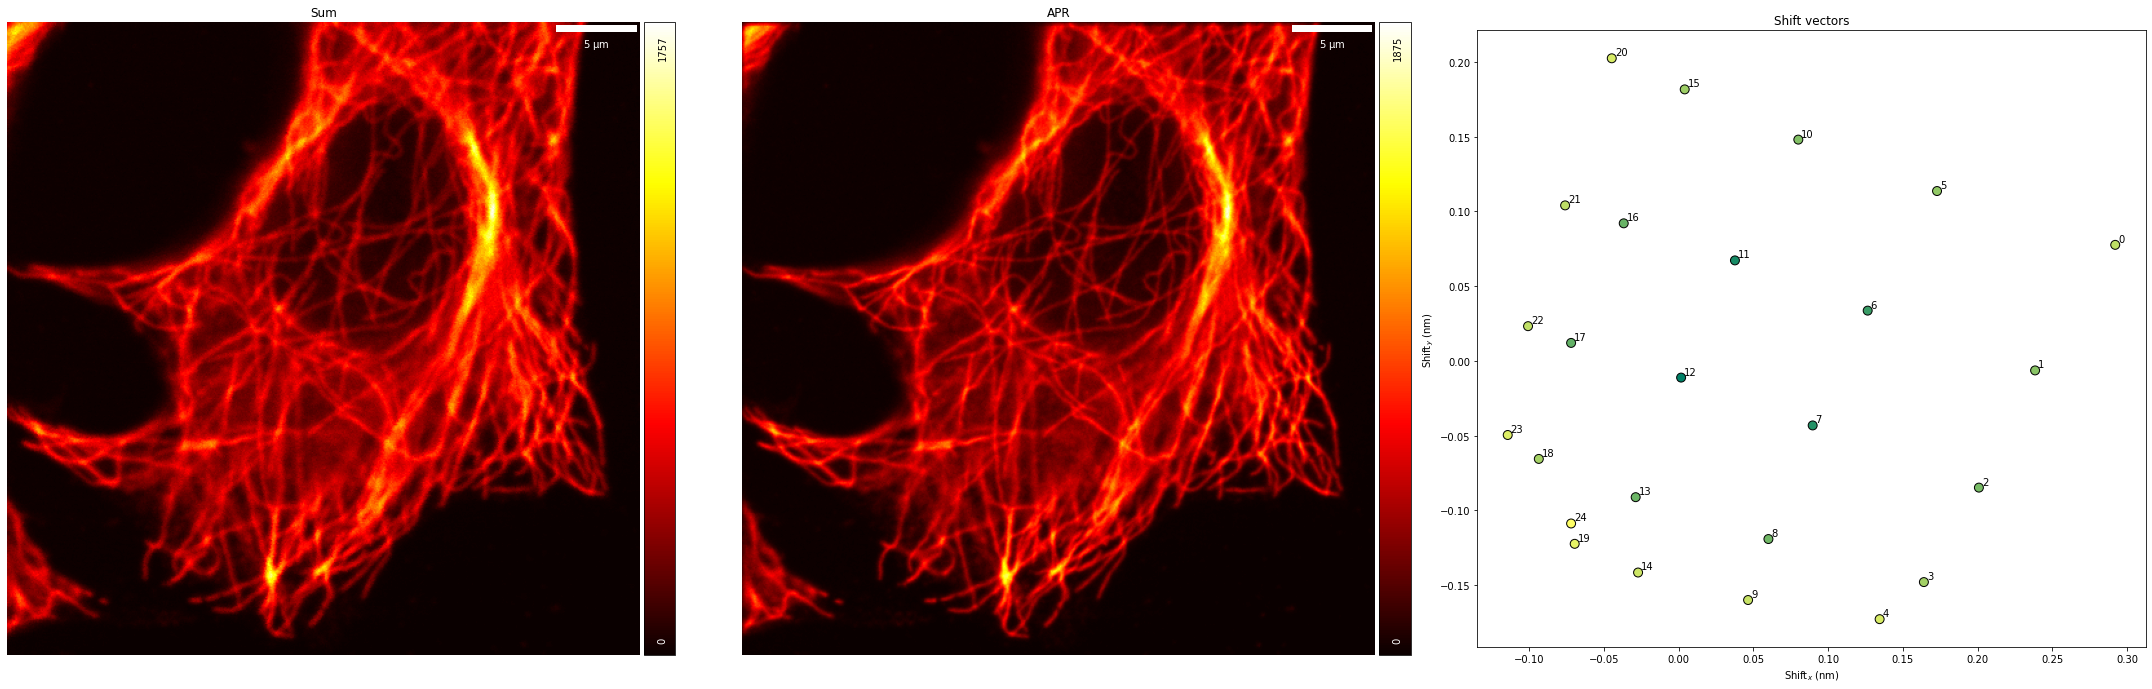

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

gr.ShowImg(img_sum, pxsize_x = pxsizex, fig = fig, ax = ax[0])
ax[0].set_title('Sum')

gr.ShowImg(img_ism_sum, pxsize_x = pxsizex, fig = fig, ax = ax[1])
ax[1].set_title('APR')

gr.PlotShiftVectors(shift, color = fingerprint, fig = fig, ax = ax[2])

fig.tight_layout()

# FRC analysis

In [14]:
data_split = data.sum( axis = (0,1) )
data_split = [data_split[:,:,::2,:], data_split[:,:,1::2,:], ]

images = []
images_sum = []
images_ism_sum = []

for n in range(2):
    images.append( data_split[n].sum(axis = -2) )
    images_sum.append( images[n].sum(axis = -1) )
    images_ism_sum.append( apr.APR(images[n], usf, ref, pxsize = pxsizex)[1].sum(axis = -1) )

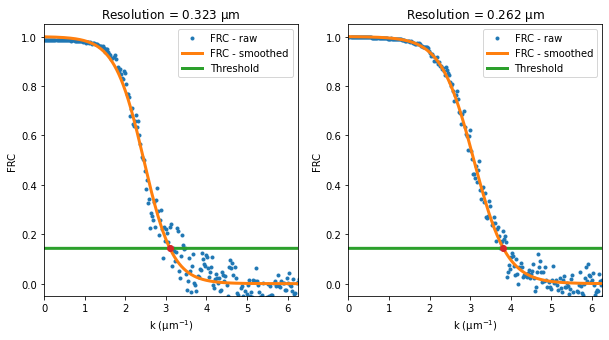

In [15]:
frc_result_sum = frc.FRC_resolution(images_sum[0], images_sum[1], px = pxsizex, method = 'fixed', smoothing = 'fit')
frc_result_ism = frc.FRC_resolution(images_ism_sum[0], images_ism_sum[1], px = pxsizex, method = 'fixed', smoothing = 'fit')

fig, ax = plt.subplots(1, 2, figsize=(10,5))

fig, ax[0] = frc.plotFRC(*frc_result_sum, fig = fig, ax = ax[0])

fig, ax[1] = frc.plotFRC(*frc_result_ism, fig = fig, ax = ax[1])

# Multi-image Deconvolution

In [16]:
img_deconv = dec.MultiImg_RL_FFT(dset_psf, dset, max_iter = 5)

Multi-image deconvolution:


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Text(0.5, 1.0, 'Deconvolution')

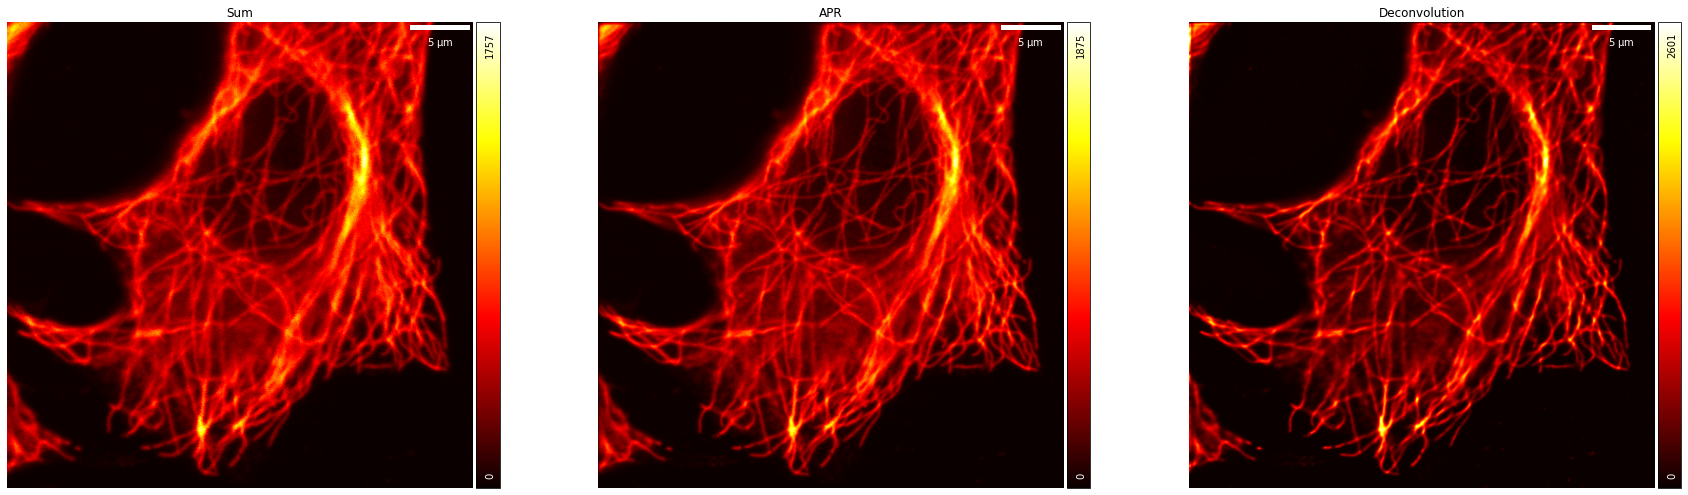

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

gr.ShowImg(img_sum, pxsize_x = pxsizex, fig = fig, ax = ax[0])
ax[0].set_title('Sum')

gr.ShowImg(img_ism_sum, pxsize_x = pxsizex, fig = fig, ax = ax[1])
ax[1].set_title('APR')

gr.ShowImg(img_deconv, pxsize_x = pxsizex, fig = fig, ax = ax[2])
ax[2].set_title('Deconvolution')

# ISM upsampling

In [19]:
dset_ds = tools.DownSample(dset, ds = 2, order = 'xyc')
dset_us = tools.UpSample(dset_ds, us = 2, order = 'xyc')

img_sum_us = dset_ds.sum(axis = -1)
img_sum_us = tools.CropEdge(img_sum_us, npx=5, edges='lrud', order = 'xy')

_, img_ism_us = apr.APR(dset_us, usf, ref, pxsize = pxsizex)
img_ism_sum_us = img_ism_us.sum(axis = -1)
img_ism_sum_us = tools.CropEdge(img_ism_sum_us, npx=10, edges='lrud', order = 'xy')

img_deconv_us = dec.MultiImg_RL_FFT(dset_psf, dset_us, max_iter = 5)
img_deconv_us = tools.CropEdge(img_deconv_us, npx=10, edges='lrud', order = 'xy')

Multi-image deconvolution:


100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


In [20]:
print(img_sum_us.shape)
print(img_ism_sum_us.shape)
print(img_deconv_us.shape)

(235, 235)
(470, 470)
(470, 470)


Text(0.5, 1.0, 'Deconvolution')

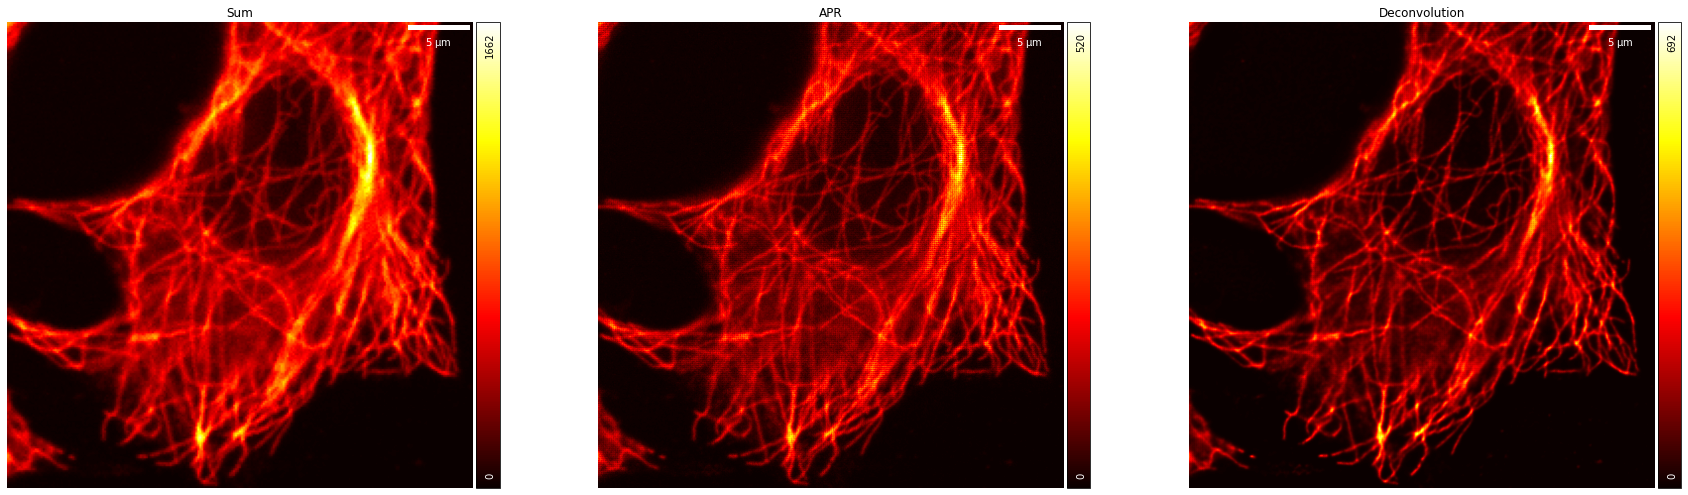

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

gr.ShowImg(img_sum_us, pxsize_x = 2*pxsizex, fig = fig, ax = ax[0])
ax[0].set_title('Sum')

gr.ShowImg(img_ism_sum_us, pxsize_x = pxsizex, fig = fig, ax = ax[1])
ax[1].set_title('APR')

gr.ShowImg(img_deconv_us, pxsize_x = pxsizex, fig = fig, ax = ax[2])
ax[2].set_title('Deconvolution')